In [1]:
import torch
import torchvision
import segmentation_models_pytorch
from pathlib import Path
from glob import glob

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
torch.cuda.device(1)
torch.cuda.current_device()

0

In [4]:
DATA_DIR = '/data2/aditya/Damage_Model/camvid_style/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'valid_annot')

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
len(os.listdir("/data2/aditya/Damage_Model/camvid_style/valid"))

321

In [6]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ["void", "damage"]
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
#         self.ids = os.listdir(images_dir)
#         self.ids = list(Path(images_dir).glob('**/*.png'))
        self.images_fps = list(Path(images_dir).glob('**/*.png'))
        self.masks_fps = list(Path(masks_dir).glob('**/*.png'))
#         self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
#         self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(str(self.images_fps[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.masks_fps[i]), 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

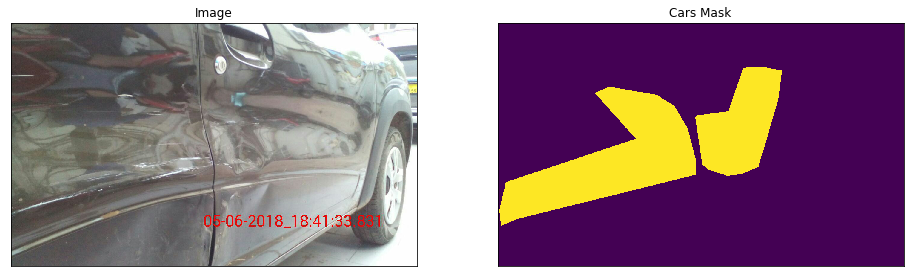

In [9]:
dataset = Dataset(x_train_dir, y_train_dir, classes=["damage"])

image, mask = dataset[200] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [10]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Resize(448, 448),
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

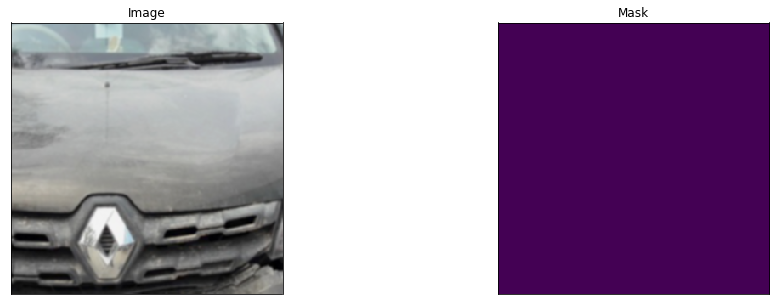

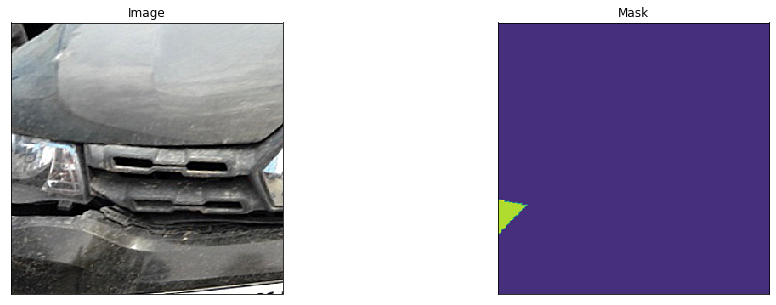

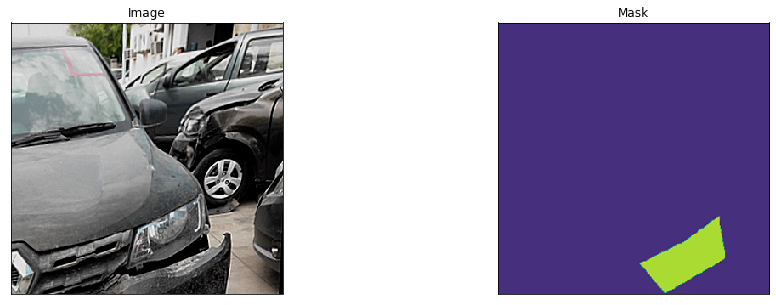

In [11]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['damage'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))


In [12]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [13]:
ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

CLASSES = ["damage"]
ACTIVATION = 'sigmoid'

In [3]:
smp.utils.losses.BCEDiceLoss??

In [14]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [15]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
#     augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
#     augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

/home/humonics/.virtualenvs/yolo/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2247: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [51]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x7f18974ec950>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [19]:
loss = smp.utils.losses.DiceLoss(1.)
metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-4},  
])

In [20]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [21]:
torch.cuda.empty_cache()

In [55]:
max_score = 0

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou']:
        max_score = valid_logs['iou']
        torch.save(model, '/data2/aditya/Damage_Model/camvid_style/best_model1.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-2
        print('Decrease decoder learning rate to 1e-2!')


Epoch: 0
valid: 100%|██████████| 40/40 [00:08<00:00,  7.74it/s, bce_dice_loss - 1.223, iou - 0.2369, f-score - 0.3717]
Model saved!

Epoch: 1
valid: 100%|██████████| 40/40 [00:05<00:00,  8.21it/s, bce_dice_loss - 1.193, iou - 0.2487, f-score - 0.3908]
Model saved!

Epoch: 2
valid: 100%|██████████| 40/40 [00:05<00:00,  8.22it/s, bce_dice_loss - 1.164, iou - 0.2625, f-score - 0.4101]
Model saved!

Epoch: 3
valid: 100%|██████████| 40/40 [00:05<00:00,  8.18it/s, bce_dice_loss - 1.14, iou - 0.2577, f-score - 0.4008] 

Epoch: 4
valid: 100%|██████████| 40/40 [00:05<00:00,  8.21it/s, bce_dice_loss - 1.109, iou - 0.2679, f-score - 0.4134]
Model saved!

Epoch: 5
valid: 100%|██████████| 40/40 [00:05<00:00,  8.10it/s, bce_dice_loss - 1.102, iou - 0.2454, f-score - 0.3845]

Epoch: 6
valid: 100%|██████████| 40/40 [00:05<00:00,  8.19it/s, bce_dice_loss - 1.073, iou - 0.2739, f-score - 0.4175]
Model saved!

Epoch: 7
valid: 100%|██████████| 40/40 [00:05<00:00,  8.18it/s, bce_dice_loss - 1.068, iou - 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



valid: 100%|██████████| 40/40 [00:05<00:00,  8.09it/s, bce_dice_loss - 1.252, iou - 0.1392, f-score - 0.2347] 

Epoch: 73
valid: 100%|██████████| 40/40 [00:05<00:00,  8.15it/s, bce_dice_loss - 1.137, iou - 0.1671, f-score - 0.2764]

Epoch: 74
train:  42%|████▏     | 57/135 [00:44<00:58,  1.33it/s, bce_dice_loss - 0.1409, iou - 0.8306, f-score - 0.9061]


KeyboardInterrupt: 

TypeError: Invalid shape (3, 448, 448) for image data

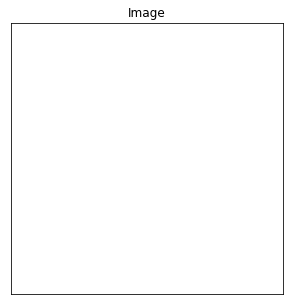

In [22]:
# valid_dataset[1]
image, mask = valid_dataset[50] # get some sample
# visualize(
#     image=image, 
#     cars_mask=mask.squeeze(),
# )
# image, mask = valid_dataset[200]
visualize(image=image, mask=mask.squeeze())

In [58]:
from PIL import Image
Image.fromarray(valid_loader.dataset[0][0])

TypeError: Cannot handle this data type

In [28]:
len(valid_loader.dataset)

10

In [63]:
albu.Resize?

In [16]:
for m in os.listdir("/data2/aditya/Damage_Model/camvid_style/valid_annot/"):
    print(m)
    image = cv2.imread('/data2/aditya/Damage_Model/camvid_style/valid_annot/'+m)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

369_IMG_20190111_112741.png
46_r  i 7955 (6).png
335_20170817_115549.png
357_IMG_20171010_145956.png
167_IMG_20181204_120702.png
239_IMG_20170918_160901460.png
513_IMG_20180607_102216.png
215_CV916322_1528440347901.png
423_IMG_4691.png
255_20170915_132924.png


In [43]:
smp.utils.losses.F??

In [1]:
import time
from tqdm import tqdm_gui
for i in tqdm_gui(range(100)):
    time.sleep(3)

/home/humonics/.virtualenvs/yolo/lib/python3.6/site-packages/tqdm/_tqdm_gui.py:45: TqdmExperimentalWarning: GUI is experimental/alpha
  warn('GUI is experimental/alpha', TqdmExperimentalWarning)


<Figure size 900x220 with 1 Axes>

KeyboardInterrupt: 

In [3]:
import fish

ModuleNotFoundError: No module named 'fish'

In [1]:
import fish
while churning:
    churn_churn()
    fish.animate()

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(fish_name)? (fish.py, line 299)